# Simulation and Optimization of HS2 Line 

##### x18203591@student.ncirl.ie

<h2>Table of Contents<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Data</a></span></li>
<li><span><a href="#Distribution-of-Signaling-Blocks" data-toc-modified-id="Distribution-of-Signaling-Blocks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Distribution of Signaling Blocks</a></span></li>
<li><span><a href="#Poisson-Events" data-toc-modified-id="Poisson-Events-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Poisson Events</a></span></li><li><span><a href="#Trains" data-toc-modified-id="Trains-4"><span class="toc-item-num">5&nbsp;&nbsp;</span>Trains</a></span></li>
<li><span><a href="#Optimisation-Part-1-to-Minimise-the-overall-average-traveling-time" data-toc-modified-id="Optimisation-Part-1-to-Minimise-the-overall-average-traveling-time-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimisation Part 1 to Minimise the overall average traveling time</a></span></li>
<li><span><a href="#OLS-model-to-get-Coefficients-for-objective-function" data-toc-modified-id="OLS-model-to-get-Coefficients-for-objective-function"><span class="toc-item-num">7&nbsp;&nbsp;</span>OLS model to get Coefficients for objective function</a></span></li>
<li><span><a href="#Objective-Function" data-toc-modified-id="Objective-Function"><span class="toc-item-num">8&nbsp;&nbsp;</span>Objective Function</a></span></li>
<li><span><a href="#Monte-Carlo-Optimisation" data-toc-modified-id="Monte Carlo Optimisation"><span class="toc-item-num">9&nbsp;&nbsp;</span>Monte Carlo Optimisation</a></span></li>
<li><span><a href="#Result-of-Optimization-Part-1" data-toc-modified-id="Result of Optimization Part 1"><span class="toc-item-num">10&nbsp;&nbsp;</span>Result of Optimization Part 1</a></span></li> 
<li><span><a href="#Optimization-Part-2-Maximise-the-throughput-of-passengers" data-toc-modified-id="Optimization Part 2 Maximise the throughput of passengers"><span class="toc-item-num">11&nbsp;&nbsp;</span>Optimization Part 2 Maximise the throughput of passengers</a></span></li>
<li><span><a href="#Result-of-Optimization-Part-2-Maximise-the-throughput-of-passengers" data-toc-modified-id="Result of Optimization Part 2 Maximise the throughput of passengers"><span class="toc-item-num">12&nbsp;&nbsp;</span>Result of Optimization Part 2 Maximise the throughput of passengers</a></span></li>

<li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">13&nbsp;&nbsp;</span>References</a></li></div>

# Load Libraries

In [107]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import string
import random
import simpy
import simpy.events as evt
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Data 

Convert distence to meters and time to seconds and calculate the distance and speed of trains using given information.

In [108]:
#Given information
S1 = 'London Euston'
S2 = 'London Old Oak Common'
S3 = 'Birmingham Interchange'
S4 = 'Birmingham Curzon Street'

# Calculate distance and speed 

distance_S2_S3 = 145000
peakRunningTime_S2_S3 = 1860
speed = int(distance_S2_S3/peakRunningTime_S2_S3)
peakRunningTime_S1_S2 = 300
distance_S1_S2 = int(speed*peakRunningTime_S1_S2)
peakRunningTime_S3_S4 = 540
distance_S3_S4 = int(speed*peakRunningTime_S3_S4)

Create Dataframe of the calculated distance speed consisting of the name of line, Direction of trains, From, To, Distance, Running time of train betweent each station, Off-Peak Running Time, Speed and Signaling Blocks between each station.

In [109]:
data = {'Line':  ['HS2', 'HS2', 'HS2'],
        'Direction': ['London-Birmingham', 'London-Birmingham', 'London-Birmingham'],
        'From': [S1, S2, S3],
        'To' : [S2, S3, S4],
        'Distance':[distance_S1_S2, distance_S2_S3, distance_S3_S4],
        'Running Time': [peakRunningTime_S1_S2, peakRunningTime_S2_S3, peakRunningTime_S3_S4],
        'Peak Running Time': [peakRunningTime_S1_S2, peakRunningTime_S2_S3, peakRunningTime_S3_S4],
        'Off-Peak Running Time': [peakRunningTime_S1_S2, peakRunningTime_S2_S3, peakRunningTime_S3_S4],
        'Speed': [speed, speed, speed],
        'Signaling Blocks': [1, 10, 2]
        
        }

df = pd.DataFrame (data, columns = ['Line','Direction', 'From', 'To', 'Distance', 'Running Time', 'Peak Running Time', 'Off-Peak Running Time', 'Speed', 'Signaling Blocks'])
df.head()

Line          Direction                    From                        To  \
0  HS2  London-Birmingham           London Euston     London Old Oak Common   
1  HS2  London-Birmingham   London Old Oak Common    Birmingham Interchange   
2  HS2  London-Birmingham  Birmingham Interchange  Birmingham Curzon Street   

   Distance  Running Time  Peak Running Time  Off-Peak Running Time  Speed  \
0     23100           300                300                    300     77   
1    145000          1860               1860                   1860     77   
2     41580           540                540                    540     77   

   Signaling Blocks  
0                 1  
1                10  
2                 2

This function is used to calculate time to travel given distance based on acceleration and max velocity.

In [110]:
def timeTo(acceleration, maximumVelocity, dist):
    """
    acceleration       constant acceleration, m/s²
    maxV    maximumum velocity, m/s
    dist       distance, km
    return  time in seconds required to travel
    """
    timeToAccelerate = maximumVelocity/acceleration          
    distaTravelled = acceleration*timeToAccelerate*timeToAccelerate                
    if (dist < distaTravelled):                
        return np.sqrt(4.0*dist/acceleration)        
    else:
       
        return 2*timeToAccelerate + (dist- distaTravelled)/maximumVelocity


In [111]:
lines=df['Line'].unique()
dl=pd.DataFrame(lines, columns=['Line'])
dl=dl.set_index('Line')
dl

Empty DataFrame
Columns: []
Index: [HS2]

Calculate Acceleration using this kinematic equation ${\Delta}{s}=v_{0}{t} + \frac{1}{2} {a}{t^2}$  [1].

In [112]:
for i in range(len(df)):
    t1=df.at[i,'Running Time']
    t2=df.at[i,'Peak Running Time']
    t3=df.at[i,'Off-Peak Running Time']
    df.at[i, 't']=min(t1, t2, t3)
                           
df['a']=4*df['Distance']/df['t']**2

In [113]:
df.head()

Line          Direction                    From                        To  \
0  HS2  London-Birmingham           London Euston     London Old Oak Common   
1  HS2  London-Birmingham   London Old Oak Common    Birmingham Interchange   
2  HS2  London-Birmingham  Birmingham Interchange  Birmingham Curzon Street   

   Distance  Running Time  Peak Running Time  Off-Peak Running Time  Speed  \
0     23100           300                300                    300     77   
1    145000          1860               1860                   1860     77   
2     41580           540                540                    540     77   

   Signaling Blocks       t         a  
0                 1   300.0  1.026667  
1                10  1860.0  0.167649  
2                 2   540.0  0.570370

Check lines and maximum acceleration on each line.

In [114]:
for l in lines:
    dl.at[l, 'max a']=df[df['Line']==l]['a'].max()
dl

max a
Line          
HS2   1.026667

Calculate the velocity of train between each station train.

In [115]:
import numpy as np
df['v']=None
for i in range(len(df)):
    t=df.at[i,'t']
    d=df.at[i,'Distance']
    line=df.at[i,'Line']
    a=dl.at[line, 'max a']
    q=t**2*a**2/4-a*d
    if q<0:
        # corresponds to the case that the train never reaches v_max
        # it has to start decelerate half way through
        q=0
    df.at[i, 'v']=t*a/2-np.sqrt(q)

In [116]:
for l in lines:
    dl.at[l, 'max v']=df[df['Line']==l]['v'].max()
dl

max a  max v
Line                 
HS2   1.026667  154.0

In [117]:
for i in range(len(df)):
    l=df.iat[i, 0]
    a=dl.at[l, 'max a']
    v=dl.at[l, 'max v']
    df.at[i, 'Drive Time']=int(timeTo(a, v, df.at[i, 'Distance']))

In [118]:
df.head()

Line          Direction                    From                        To  \
0  HS2  London-Birmingham           London Euston     London Old Oak Common   
1  HS2  London-Birmingham   London Old Oak Common    Birmingham Interchange   
2  HS2  London-Birmingham  Birmingham Interchange  Birmingham Curzon Street   

   Distance  Running Time  Peak Running Time  Off-Peak Running Time  Speed  \
0     23100           300                300                    300     77   
1    145000          1860               1860                   1860     77   
2     41580           540                540                    540     77   

   Signaling Blocks       t         a        v  Drive Time  
0                 1   300.0  1.026667      154       300.0  
1                10  1860.0  0.167649  81.4293      1091.0  
2                 2   540.0  0.570370     92.4       420.0

In [119]:
df['Peak Dwell Time']=df['Peak Running Time']-df['Drive Time']

In [120]:
df['Off-Peak Dwell Time']=df['Off-Peak Running Time']-df['Drive Time']

In [121]:
df=df.drop(columns=['t', 'a', 'v', 'Running Time', 'Peak Running Time', 'Off-Peak Running Time'])

In [122]:
df.head()

Line          Direction                    From                        To  \
0  HS2  London-Birmingham           London Euston     London Old Oak Common   
1  HS2  London-Birmingham   London Old Oak Common    Birmingham Interchange   
2  HS2  London-Birmingham  Birmingham Interchange  Birmingham Curzon Street   

   Distance  Speed  Signaling Blocks  Drive Time  Peak Dwell Time  \
0     23100     77                 1       300.0              0.0   
1    145000     77                10      1091.0            769.0   
2     41580     77                 2       420.0            120.0   

   Off-Peak Dwell Time  
0                  0.0  
1                769.0  
2                120.0

In [123]:
df['Peak Dwell Time'].mean()

296.3333333333333

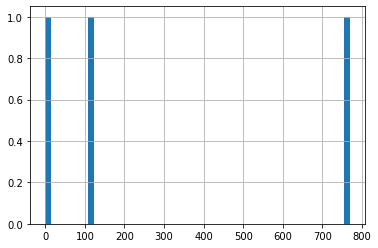

In [124]:
df['Peak Dwell Time'].hist(bins=50)

In [125]:
df['Off-Peak Dwell Time'].mean()

296.3333333333333

In [126]:
df['Off-Peak Dwell Time'].std()

413.7152805170886

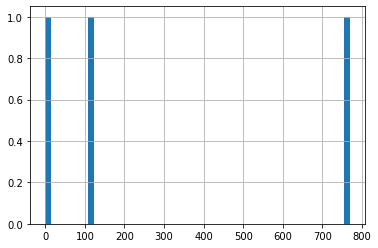

In [127]:
df['Off-Peak Dwell Time'].hist(bins=50)

## Distribution of Signaling Blocks
Below example shows the distribution of signalling blocks. All the values of Distance, Running_Time and Dwell_Time are calculated using the above calculations and formulae.
This is the example of 13 signalling blocks, similarly, multiple data is been created consisting of 4 to 17 blocks in each file and number of blocks, Number of Trains, Travel Times and Total Passengers are programmatically calculated for each simulation and stored in a CSV which will act as an input for the Optimization problem.

In [128]:
train_data=pd.read_csv('/Users/ninadmohite/Desktop/SimulationData.csv')
train_data

Block_Number           From_Location               To_Location  Distance  \
0              1           London Euston     London Old Oak Common      25.0   
1              2   London Old Oak Common                        S3      15.0   
2              3                      S3                        S4      15.0   
3              4                      S4                        S5      15.0   
4              5                      S5                        S6      15.0   
5              6                      S6                        S7      15.0   
6              7                      S7                        S8      15.0   
7              8                      S8                        S9      15.0   
8              9                      S9                       S10      15.0   
9             10                     S10                       S11      15.0   
10            11                     S11    Birmingham Interchange      10.0   
11            12  Birmingham Interchange                       S13      22.5   
12            13                     S13  Birmingham Curzon Street      22.5   

    Running_Time  Actual_Running_Time  Dwell_Time    b  
0            5.0               466.20           0  0.0  
1            3.0               235.20          20  NaN  
2            3.0               180.00           0  NaN  
3            3.0               180.00           0  NaN  
4            3.0               180.00           0  NaN  
5            3.0               180.00           0  NaN  
6            3.0               180.00           0  NaN  
7            3.0               180.00           0  NaN  
8            3.0               180.00           0  NaN  
9            3.0               180.00           0  NaN  
10           4.0               231.00          20  NaN  
11           4.5               327.60           0  NaN  
12           4.5               385.92           0  NaN

## Poisson Events
The Poisson's probability distribution is used to characterize the statistics of events [4].
The HS2 train model assumes that the passenger arrivals at station follow a Poisson process, the number of alighting passengers at each station follows a Poisson distribution and the train travel time is affected due to it.
*Below are the values of the Poisson distribution obtained for simulating number passengers of the passengers arriving at the train stations.*

Poisson Distributions are used to solve statistics of events
It is calculated using **from scipy.stats import poisson** package where poisson.rvs() function gives distribution taking the input as **mu** which is the mean value, **size** stating the size of the distribution and **random_state**.

**Seaborn** is used to plot the distributions using **distplot()**. 

Lists of distributions are passed to the **line()** function where the passengers are getting on at London Euston station and since it id the first station passengers are not getting off hence only get on function is used. 

Then they are passed to the **process()** function in **Train** class and to simulate passengers movement on each of the stations.

The code was done with the help of scipy documentation [2].

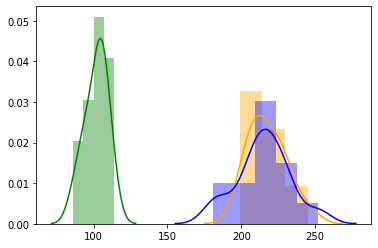

In [129]:
s = poisson.rvs(mu=220, size=14, random_state=41) # generate values according to poisson distribution
                                                  # of 14 values using the mean as 220 and random state as 41
       
w = poisson.rvs(mu=100, size=14, random_state=20)
        
q = poisson.rvs(mu=220, size=14, random_state=17)

sns.distplot(s, color= "Orange")
sns.distplot(w, color= "Green")
sns.distplot(q, color= "Blue")



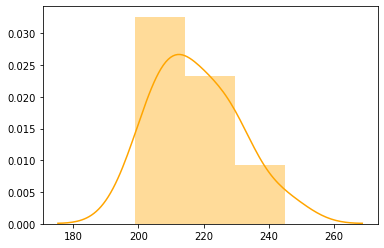

In [130]:
sns.distplot(s, color="Orange")

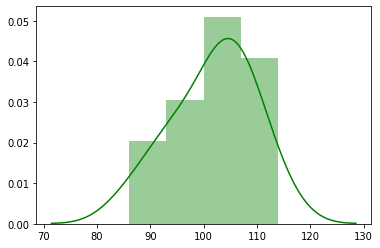

In [131]:
sns.distplot(w, color="Green")

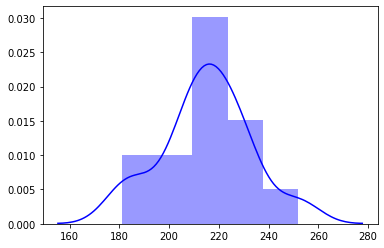

In [132]:
sns.distplot(q, color="Blue")

## Trains

The key entities for the simulation are the trains which will run through the process. Hence **Train** class is used to simulate the entire process. It consists of **process(), getOn() and getOff()** functions. 

**process()** function is the main function which is called in the **line()** function, it mainly simulates the profess of train flow and calculation of total time taken by each train including the dwell time is done in this function, also maintaining passenger count is done and stored in a dictionary (passengers{}) where the key is the train number and value is the total passenger travelled in the train through its entire journey from London Euston to Birmingham Curzon Street.

Logic is written in such a way that at the starting station which is London Euston only **getOn()** function is called which is in the **line()** function and at London Euston since it is the starting station the passengers will get on. Whenever the train reaches London Old Oak Common and Birmingham Interchange function **getOff()** and then the difference is calculated and stored in a variable and then function **getOn** is called where passengers value is updated depending on the number of passengers getting in. This is done for each train at each station to get the total number passengers in a train and then stored in a dictionary and finally, the total sum of passengers is calculated to get the final tally of passengers travelling with the configuration of the system with a particular number of signalling blocks and total numbers of trains. Similarly, total travel time for each train is calculated which is the sum of running time and dwell time and then the travel time of each train is added to get total travel time.

Finction **line()** is called in order to the simulate enviroment using **env.process()** in this function the the passengers gets on in the train at London Euston station and the object for train class are passed so that the functions within train class can access those obects. Here the logic of total number of trains to be passed is given as well. 

In [150]:
class Train(object):  
    def __init__(self, i, j, train_data, data1, data2, w, q, s, maxP = 620):
        self.name = ' [Train '+f"{i:2d}"+']'
        self.next = ' [Train '+f"{j:2d}"+']'
        self.train_data = train_data
        self.maxP = maxP
        self.p = 0
        self.data1 = data1
        self.data2 = data2
        self.w = w
        self.q = q
        self.i = i
        self.s = s
        self.passengers={}
    def process(self):
        total=0
        z=0
        #passengers={}
        for block in self.train_data['Block_Number']:
            data = self.train_data[self.train_data['Block_Number'] == block]
            stations =   data['From_Location'].to_list()
            stations +=  [data['To_Location'].to_list()[-1]]
            From_Location = stations[0]
            To_Location = stations[1]
            
            for Location in stations[0:1]:
                self.data1 = train_data[train_data['From_Location'] == Location]
                drivetime = self.data1.iloc[0].at['Actual_Running_Time']
                dwelltime = self.data1.iloc[0].at['Dwell_Time']
                self.data1['b'] = 1
       
                yield env.timeout(dwelltime)
                print(f"{now():s} {self.name:s} dep from {From_Location:s} for {To_Location:s}")
                yield env.timeout(drivetime)
                self.passengers.update({f"{self.name}": self.s[self.i]})
               
                if To_Location not in ["S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S13", "Birmingham Curzon Street"]:
                    print(f"{now():s} {self.name:s} arr {To_Location:s}")
                    yield env.process(self.getOff(self.w[self.i],To_Location))
                    r = self.s[self.i]-self.w[self.i]
                    
                    yield env.process(self.getOn(self.q[self.i], To_Location))
                    r += self.q[self.i]
                    r = self.passengers[f"{self.name}"]
                    self.i+=1
                else:
                    print(f"{now():s} {self.name:s} arr {To_Location:s}")
                
                z = dwelltime+drivetime
                total+=z
                
                self.data2 = train_data[train_data['From_Location'] == To_Location]
                self.data2['b'] = 1
                yield env.timeout(5)
                self.data1['b'] = 0
        #print(self.passengers)


    def getOff(self, num, at):
        
        if (self.p >= num):
            print(f"{num:d} passengers got off at {at}")
            self.p -= num
        else:
            num = self.p
            print(f"train is empty - only {num:d} passengers got off at {at}")
            self.p = 0
            yield env.timeout(1)
 
    def getOn(self, num, at):
        if (self.maxP is None) or (self.p + num <= self.maxP):
            print(f"{num:d} passengers got on at {at}")
            self.p += num
        else:
            num = self.maxP - self.p
            print(f"train is full - only {num:d} passengers got on at {at}")
            self.p = self.maxP
            yield env.timeout(1)



In [152]:
def line(w,s,q,start=6*3600, stop=7*3600, timing=300):
        data1 = train_data[0:1]
        data2 = pd.DataFrame()
        
        yield env.timeout(start-env.now) # the line starts operating at 6am
        for i in range(int((stop-start)/timing)):
             if data1['b'][0] == 0:
                 print(f'Block 1 is free next train free to enter')
                 j = i + 1
                 t = Train(i, j, train_data, data1, data2,w,q,s)
                 env.process(t.process())
                 env.process(t.getOn(s[i], "London Euston"))
                 yield env.timeout(timing)
                         
def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now():
    return daytime(env.now)   
 
 
env = simpy.Environment()  
env.process(line(w,s,q))
env.run()


Block 1 is free next train free to enter
209 passengers got on at London Euston
06:00:00  [Train  0] dep from London Euston for London Old Oak Common
Block 1 is free next train free to enter
228 passengers got on at London Euston
06:05:00  [Train  1] dep from London Euston for London Old Oak Common
06:07:46  [Train  0] arr London Old Oak Common
102 passengers got off at London Old Oak Common
211 passengers got on at London Old Oak Common
06:08:11  [Train  0] dep from London Old Oak Common for S3
Block 1 is free next train free to enter
199 passengers got on at London Euston
06:10:00  [Train  2] dep from London Euston for London Old Oak Common
06:12:06  [Train  0] arr S3
06:12:11  [Train  0] dep from S3 for S4
06:12:46  [Train  1] arr London Old Oak Common
114 passengers got off at London Old Oak Common
205 passengers got on at London Old Oak Common
06:13:11  [Train  1] dep from London Old Oak Common for S3
Block 1 is free next train free to enter
205 passengers got on at London Euston


## Optimisation Part 1 to Minimise the overall average traveling time

Here the results generated from all the combination of simulation is been stored in a csv file which is used to get optimum solution.  The file consists of Number of blocks, Number of Trains, Travel Time Pass and Passengers. Total 14 different combination are made in this case.

In [135]:
# Travel Optimisation
sim=pd.read_csv('/Users/ninadmohite/Downloads/Simulation_Result.csv')
simulation_data = sim
pd.options.mode.chained_assignment = None

 

simulation_data

No of Blocks  No of Trains  Travel Time Pass  Passengers
0              4             7              3850        9339
1              5             7              4023       10299
2              6             8              4196       12027
3              7             8              4369       11979
4              8             9              4542       13122
5              9             9              4718       13146
6             10            10              4892       15030
7             11            11              5058       15531
8             12            11              5234       16278
9             13             9              6725       12999
10            14             9              6936       12834
11            15            10              7146       14313
12            16            10              7350       14745
13            17            10              7554       14643

## OLS model to get Coefficients for objective function

OLS  model from **statsmodels.api** is used to calculate co-efficients for objective function. The target value (dependent variable) is total travel time and the predictors are number of blocks and number of trains. In the model sumary we can see the coefficients with respect to the data passed is generated where constant is 4901.9146, coefficient of train(x) is -401.2442	and coefficient of blocks(y) is 403.5745.

In [136]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
pd.options.mode.chained_assignment = None
target = pd.DataFrame(simulation_data['Travel Time Pass'])
predictor = pd.DataFrame(simulation_data[['No of Blocks', 'No of Trains']])
predictor = sm.add_constant(predictor)

 

model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()

 

/Users/ninadmohite/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/ninadmohite/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Travel Time Pass   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     539.2
Date:                Sun, 10 May 2020   Prob (F-statistic):           1.05e-11
Time:                        20:31:18   Log-Likelihood:                -88.163
No. Observations:                  14   AIC:                             182.3
Df Residuals:                      11   BIC:                             184.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4901.9146    337.519     14.523      0.000    4159.041    5644.788
No of Blocks   403.5745     14.611     27.621      0.000     371.415     435.734
No of Trains  -401.2442     47.294     -8.484      0.000    -505.337    -297.151
==============================================================================
Omnibus:                        1.525   Durbin-Watson:                   2.338
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                0.825
Skew:                          -0.012   Prob(JB):                        0.662
Kurtosis:                       1.811   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Objective Function

The function f returns objective function which is generated using coefficients obtained using linear regression.

In [137]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np

#linear regression to form the objective equation

def f(x,y):
    return 4901.9146 - 401.2442*x +403.5745*y

 

## Monte Carlo Optimisation

Function monte_carlo is used to get the optimazion result which rely on repeated random sampling to obtain results [3]. It takes value n which is number of random walks, xmin is the minumum number of trains and xmax is maximum number of trains and ymin is minimum number of blocks and ymax is maximum number of blocks. It returns the value of the optimum result.

In [138]:
import random
random.seed(0)

 
def monte_carlo(n, xmin=7, xmax=11, ymin=4, ymax=17):
    x = [ random.randint(xmin, xmax) for i in range(n)]
    y = [ random.randint(ymin, ymax) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    fmin = f(xp[0], yp[0])
    for i in range(1, len(x)):
        fi = f(x[i], y[i])

 

        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi

 

        xs = np.linspace(xmin, xmax, 100)
        ys = np.linspace(ymin, ymax, 100)
        xx, yy = np.meshgrid(xs, ys)
        z=f(xx, yy)
        
        fig, ax = plt.subplots(1, 1)
        fig.set_figwidth(6)
        fig.set_figheight(5)
        cs = ax.contourf(xs, ys, z, 100)
        fig.colorbar(cs, ax=ax)
        
        plt.scatter(x, y, c='red', marker='.')
        plt.plot(xp, yp, c='red')

    return len(xp), xp[-1], yp[-1], f(xp[-1], yp[-1])
 






## Result of Optimization Part 1

The optimum value obtained is 10 and 4 which is where 10 is the optimum number of trains and 4 is the optimum number of blocks and minimum average traveling time is 2503 seconds which is roughly 41.7 minutes.

/Users/ninadmohite/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(7, 10, 4, 2503.7706)

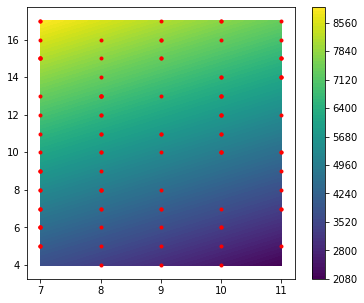

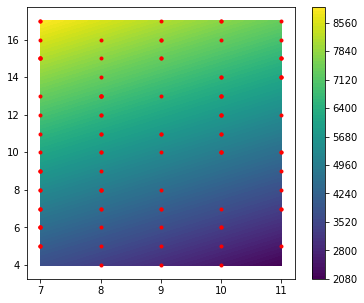

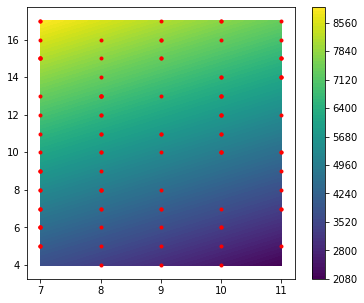

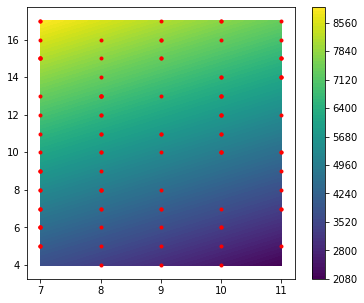

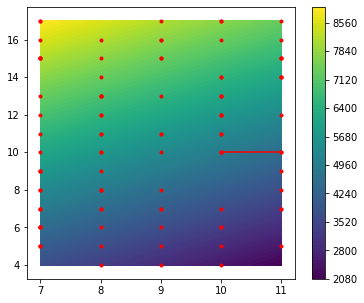

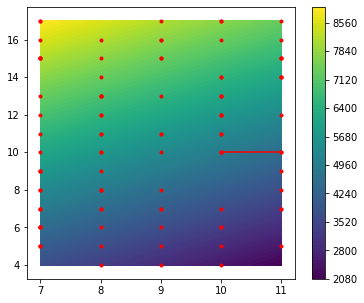

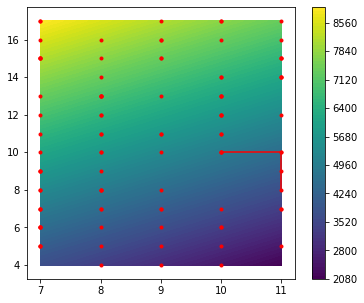

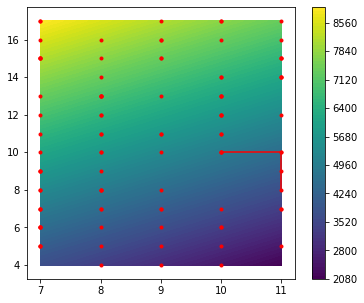

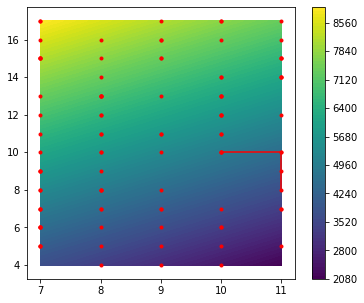

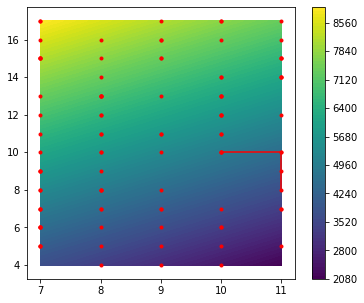

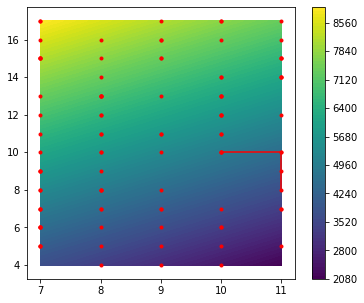

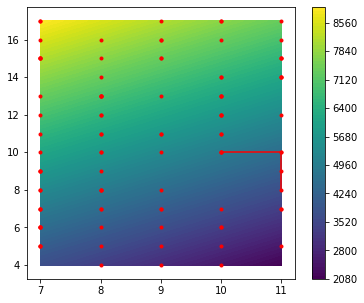

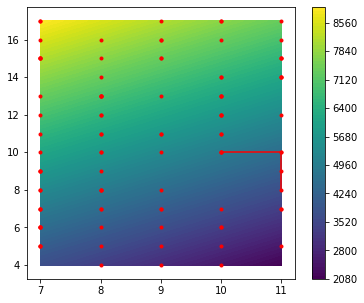

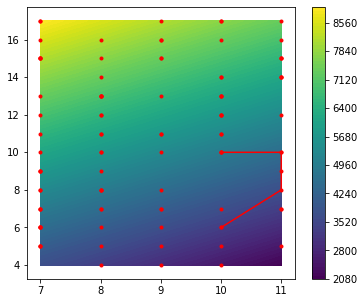

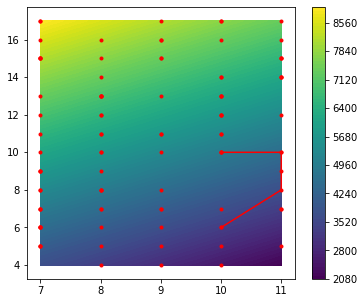

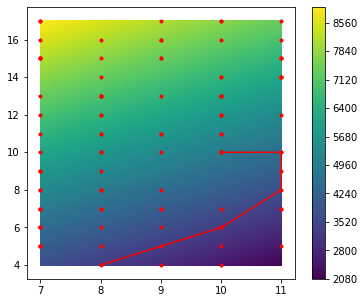

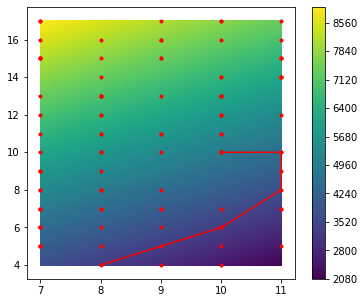

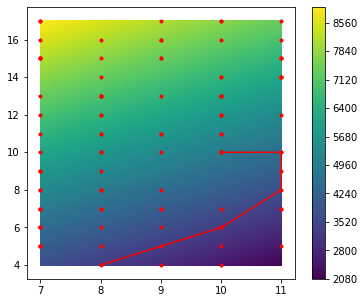

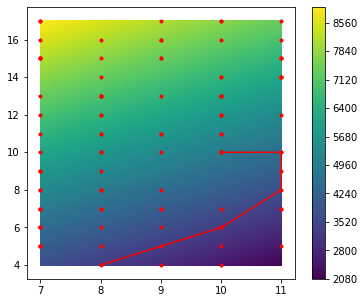

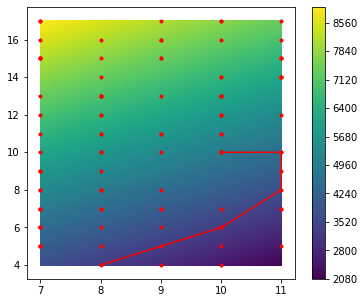

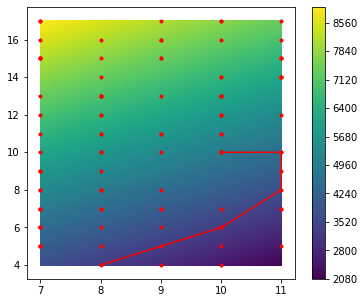

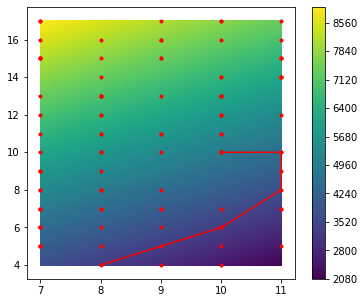

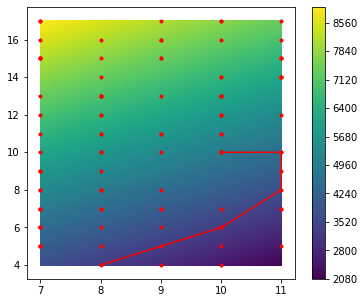

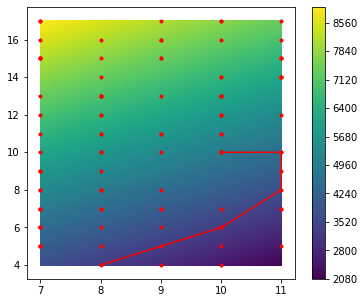

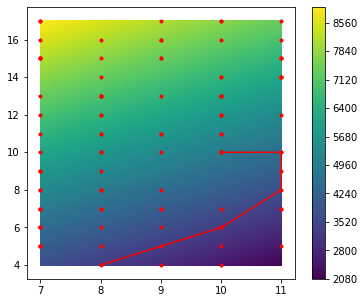

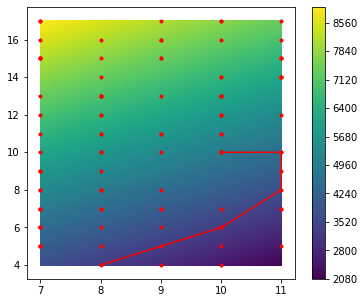

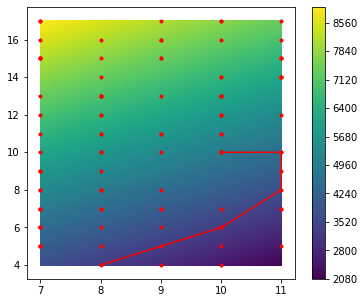

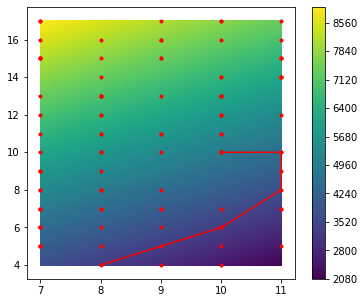

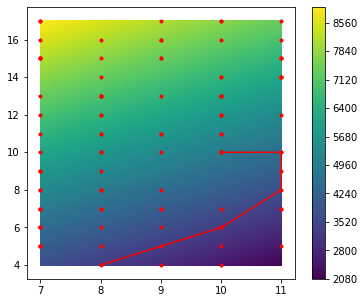

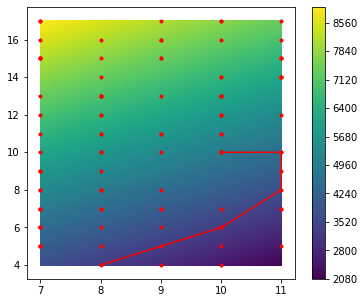

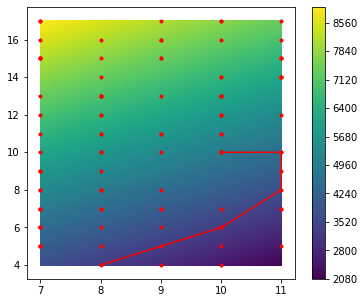

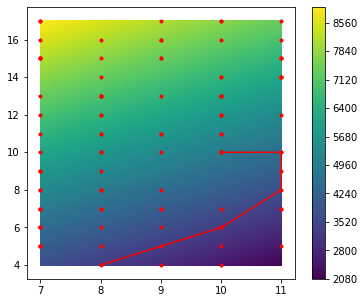

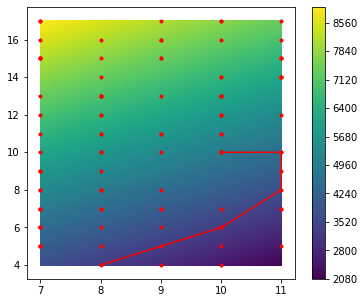

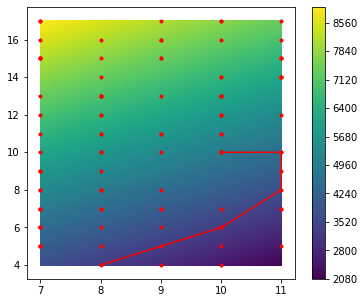

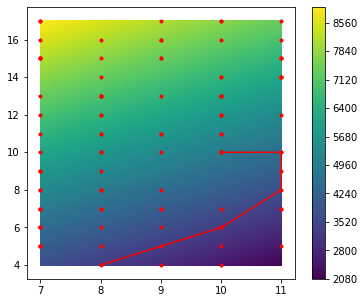

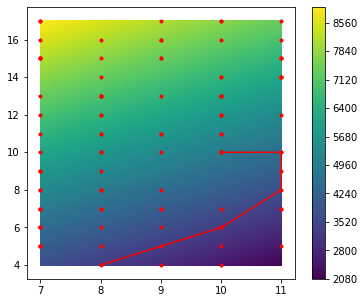

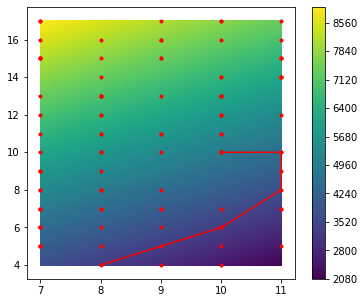

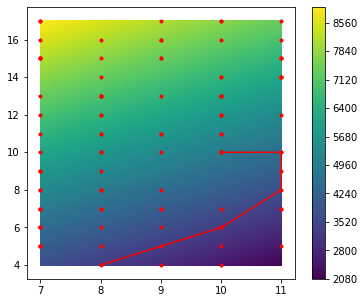

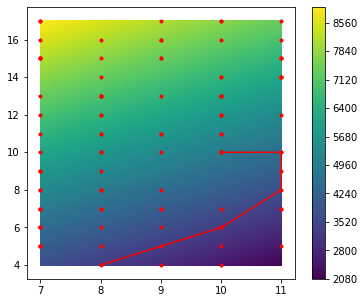

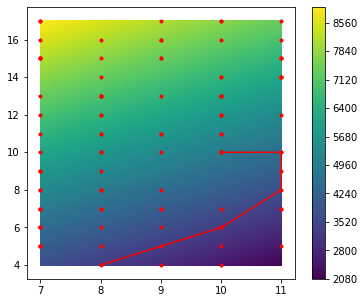

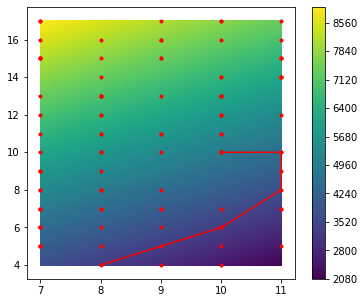

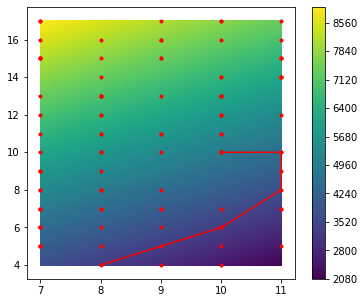

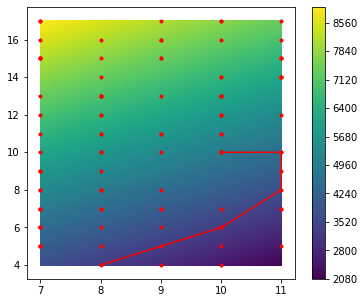

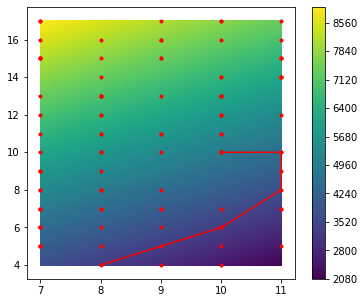

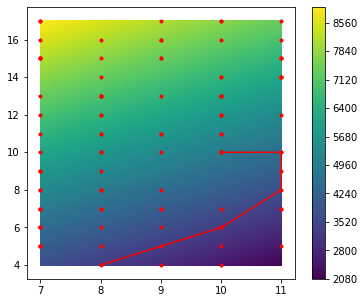

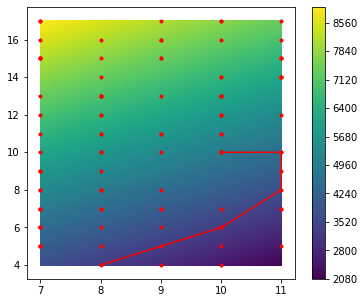

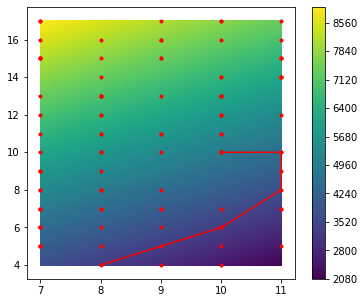

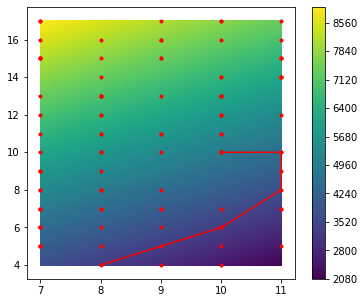

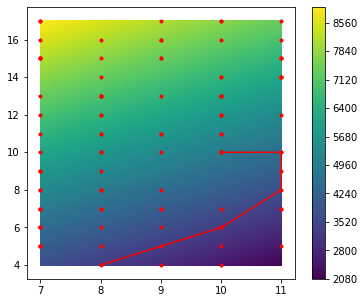

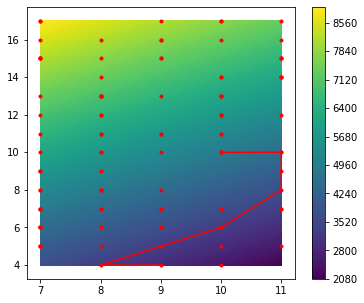

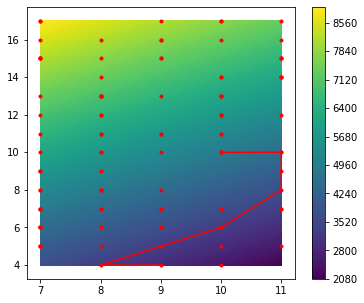

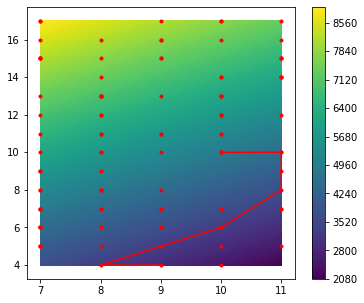

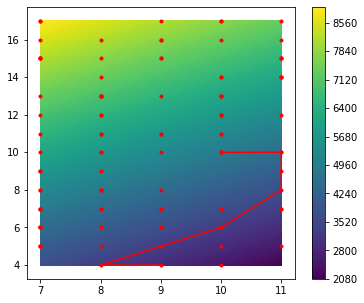

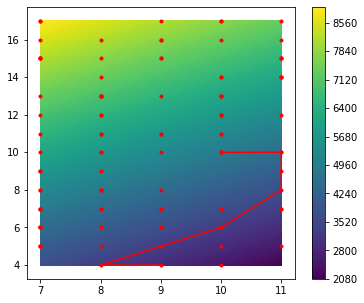

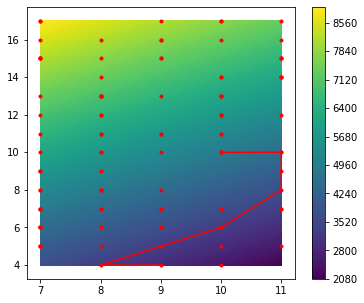

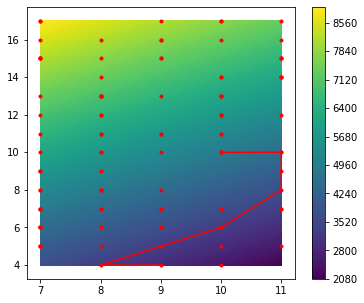

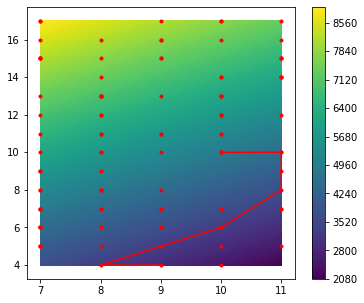

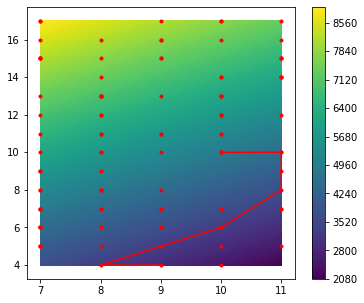

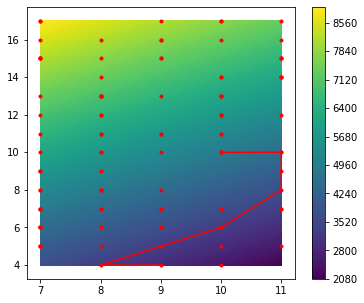

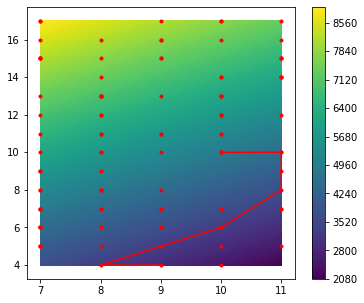

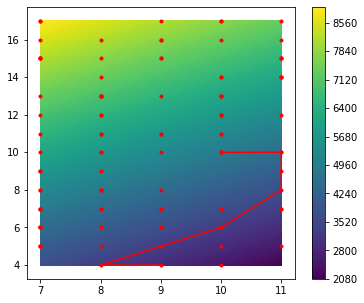

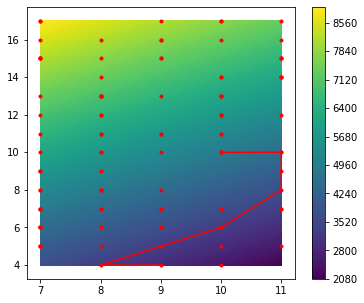

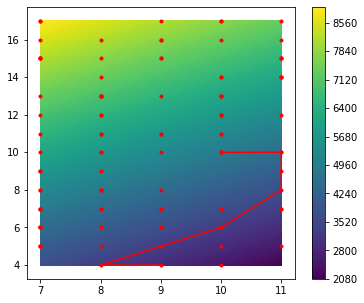

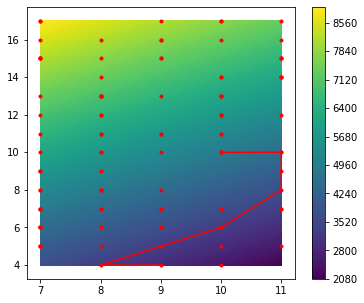

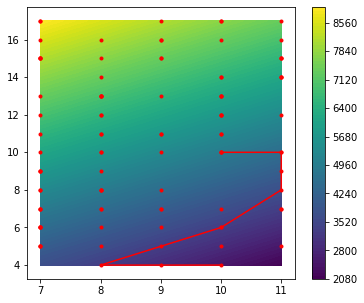

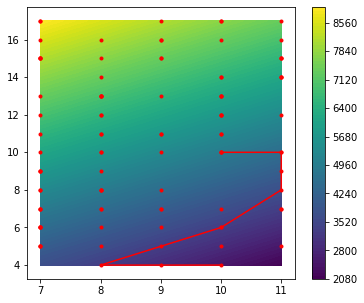

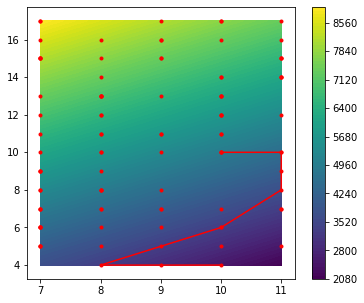

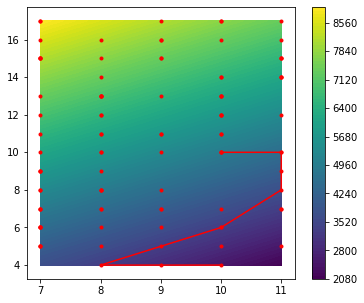

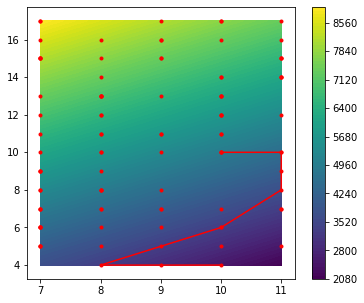

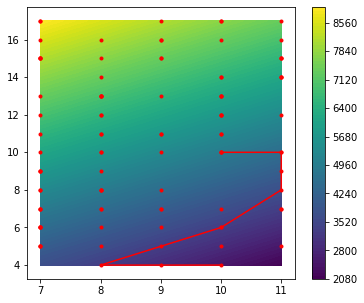

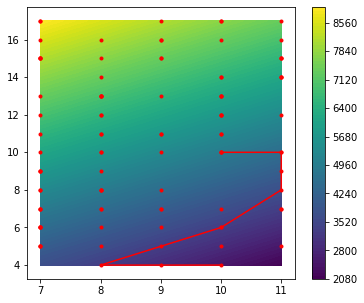

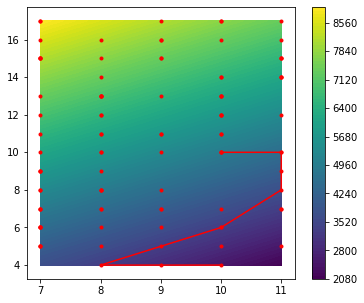

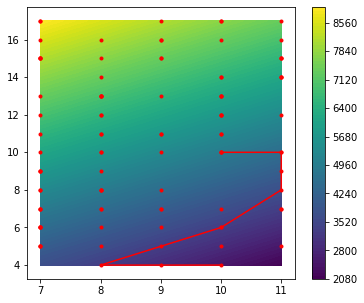

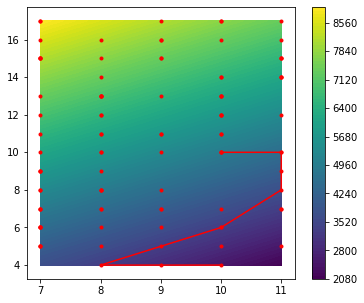

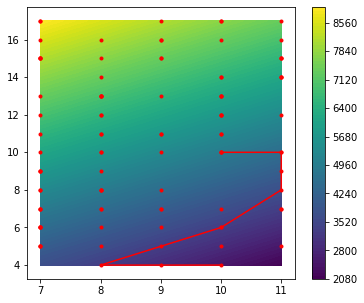

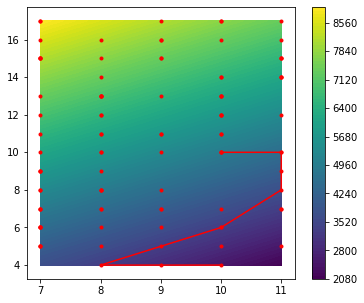

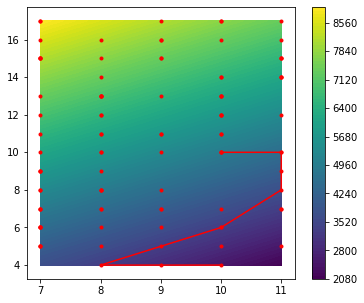

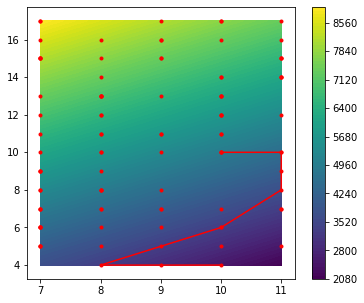

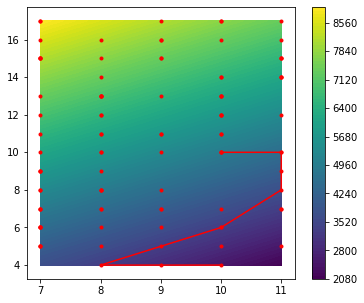

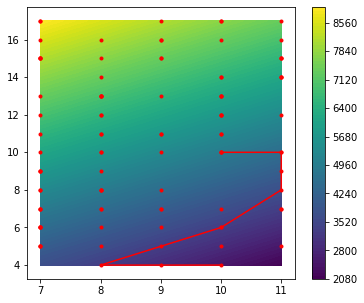

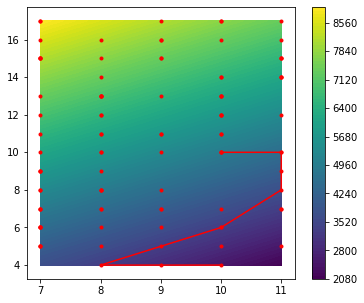

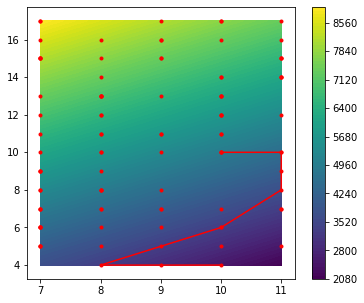

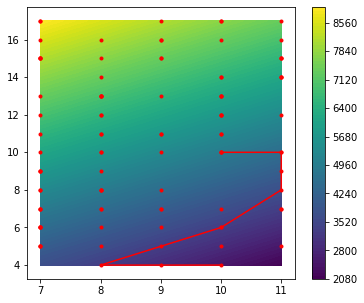

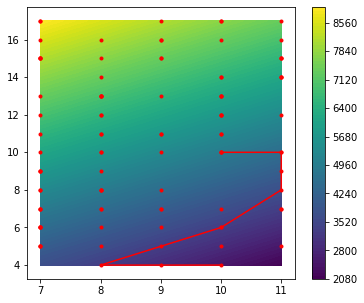

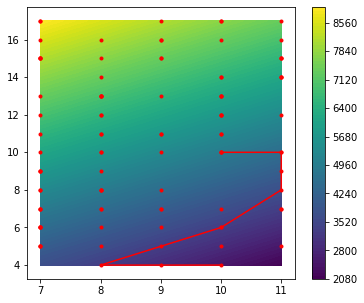

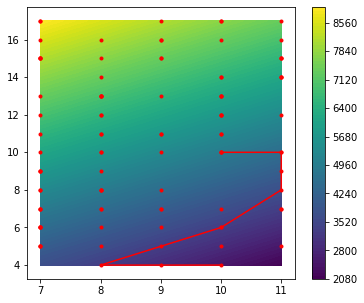

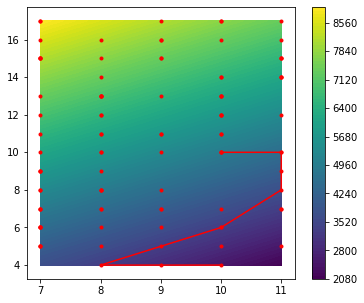

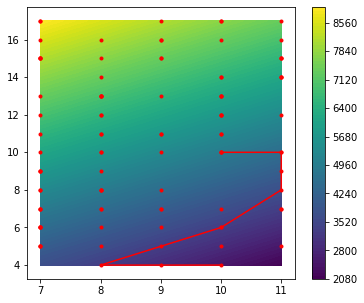

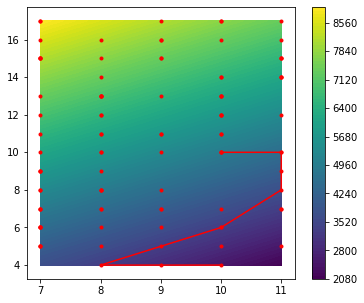

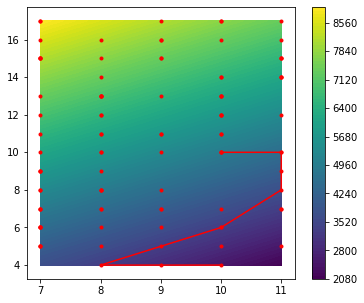

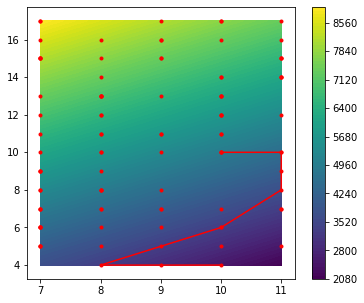

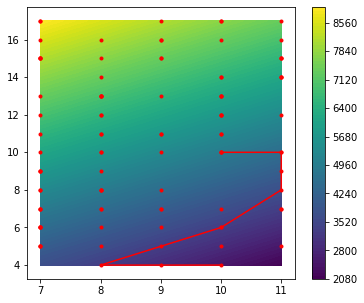

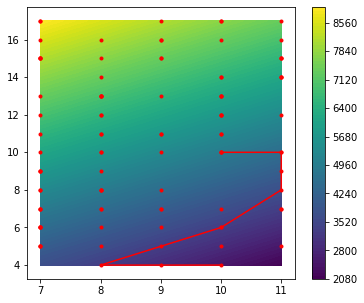

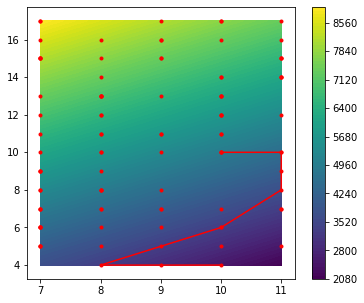

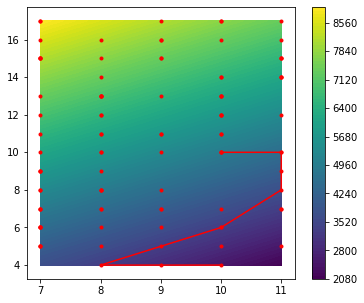

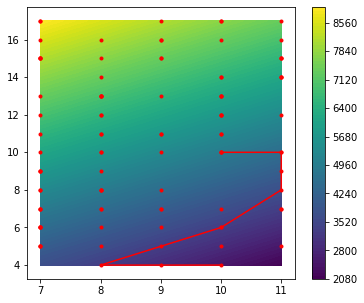

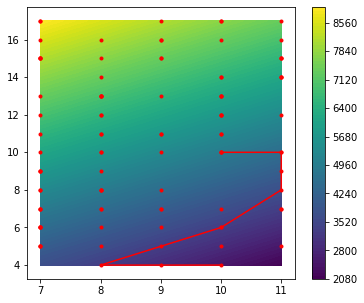

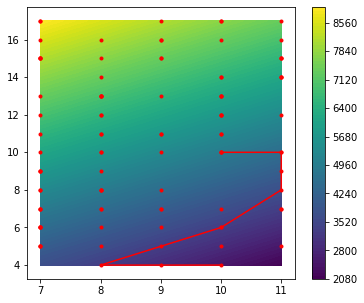

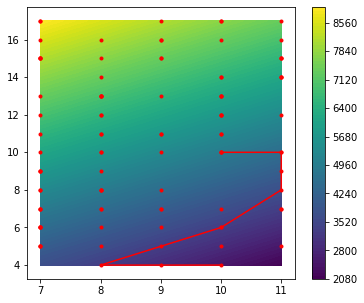

In [139]:
random.seed(41)
monte_carlo(100)

## Optimization Part 2 Maximise the throughput of passengers


OLS  model from **statsmodels.api** is used to calculate co-efficients for objective function. The target value (dependent variable) is total number of passengers and the predictors are number of blocks and number of trains. In the model sumary we can see the coefficients with respect to the data passed is generated where constant is -455.5515	, coefficient of train(x) is 1514.8953		and coefficient of blocks(y) is -8.4618.

In [141]:
pd.options.mode.chained_assignment = None
target = pd.DataFrame(simulation_data['Passengers'])
predictor = pd.DataFrame(simulation_data[['No of Blocks', 'No of Trains']])
predictor = sm.add_constant(predictor)

 

model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     160.3
Date:                Sun, 10 May 2020   Prob (F-statistic):           7.32e-09
Time:                        20:32:02   Log-Likelihood:                -101.67
No. Observations:                  14   AIC:                             209.3
Df Residuals:                      11   BIC:                             211.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -455.5515    885.613     -0.514      0.617   -2404.772    1493.669
No of Blocks    -8.4618     38.338     -0.221      0.829     -92.844      75.920
No of Trains  1514.8953    124.094     12.208      0.000    1241.766    1788.025
==============================================================================
Omnibus:                        2.826   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                1.617
Skew:                          -0.830   Prob(JB):                        0.446
Kurtosis:                       2.878   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The function f2 returns objective function which is generated using coefficients obtained using linear regression.

In [142]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np

#linear regression to form the objective equation

def f2(x,y):
    return -455.5515 + 1514.8953*x -8.4618*y

Function monte_carlo2 is used to get the optimazion result which rely on repeated random sampling to obtain results. It takes value n which is number of random walks, xmin is the minumum number of trains and xmax is maximum number of trains and ymin is minimum number of blocks and ymax is maximum number of blocks. It returns the value of the optimum result.

In [143]:
import random
random.seed(0)

 
def monte_carlo2(n, xmin=7, xmax=11, ymin=4, ymax=17):
    x = [ random.randint(xmin, xmax) for i in range(n)]
    y = [ random.randint(ymin, ymax) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    fmin = f(xp[0], yp[0])
    for i in range(1, len(x)):
        fi = f(x[i], y[i])

 

        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi

 

        xs = np.linspace(xmin, xmax, 100)
        ys = np.linspace(ymin, ymax, 100)
        xx, yy = np.meshgrid(xs, ys)
        z=f(xx, yy)
        
        fig, ax = plt.subplots(1, 1)
        fig.set_figwidth(6)
        fig.set_figheight(5)
        cs = ax.contourf(xs, ys, z, 100)
        fig.colorbar(cs, ax=ax)
        
        plt.scatter(x, y, c='red', marker='.')
        plt.plot(xp, yp, c='red')

    return len(xp), xp[-1], yp[-1], f2(xp[-1], yp[-1])

## Result of Optimization Part 2 Maximise the throughput of passengers

The optimum value obtained is 7 and 17 which is where 7 is the optimum number of trains and 17 is the optimum number of blocks and maximum throughput of passengers is 10004 passengers per hour.

/Users/ninadmohite/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(7, 10, 4, 2503.7706)

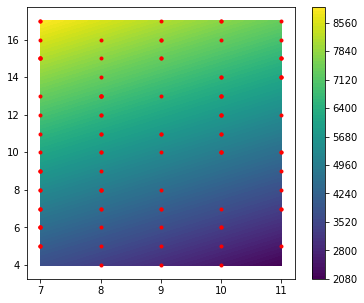

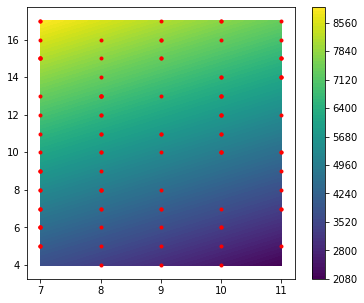

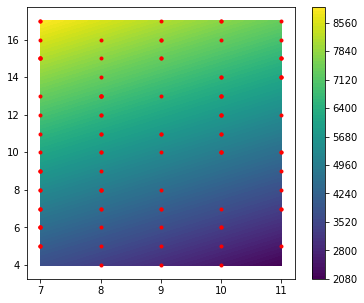

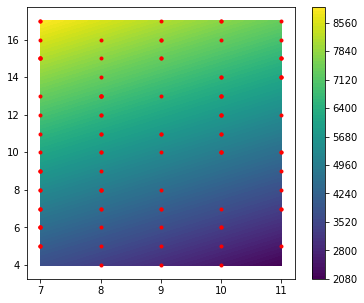

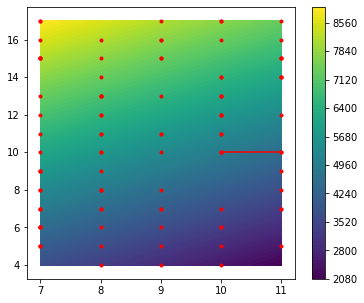

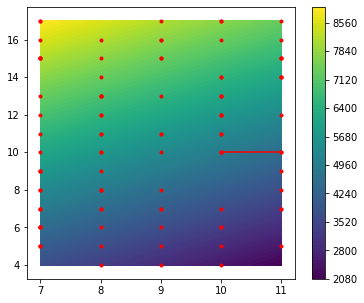

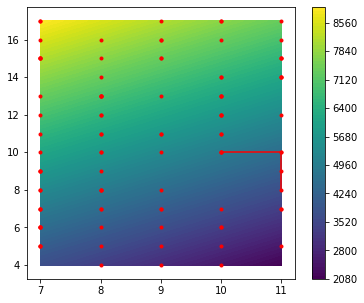

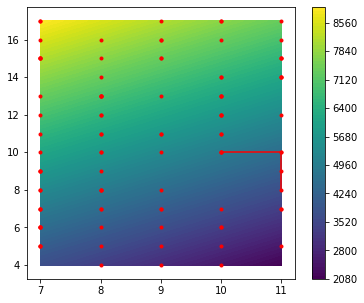

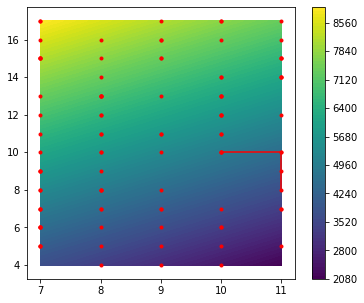

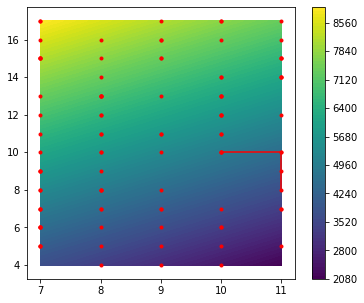

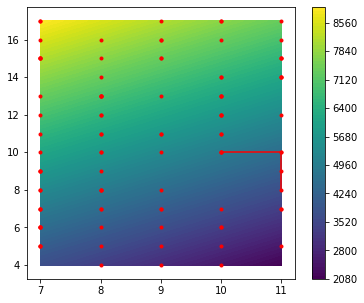

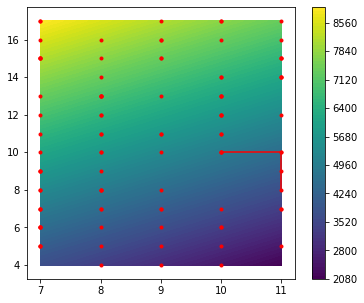

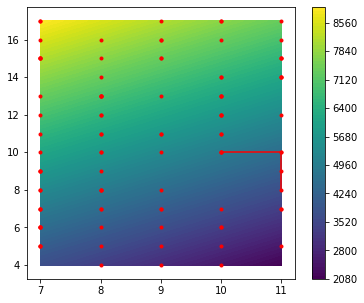

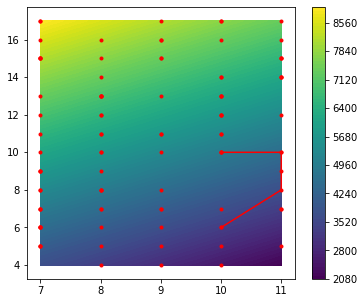

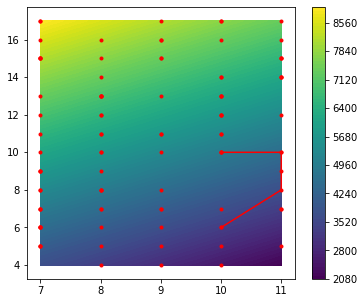

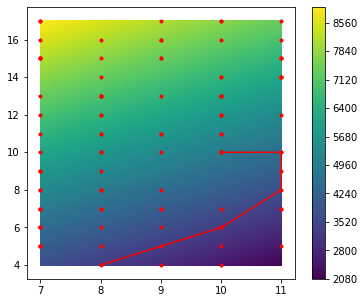

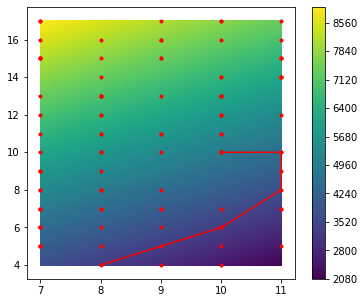

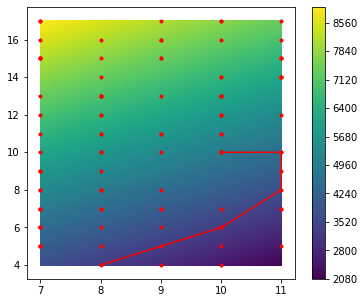

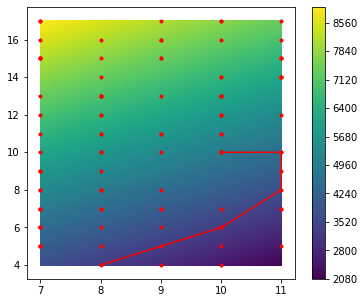

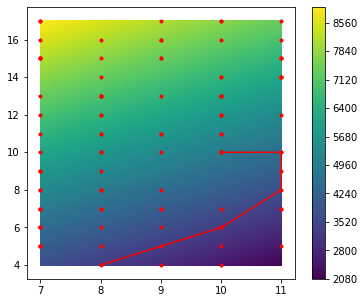

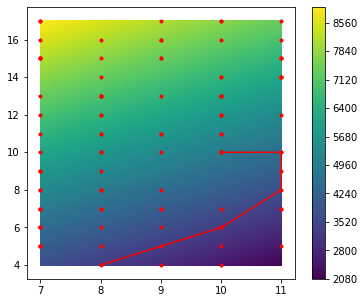

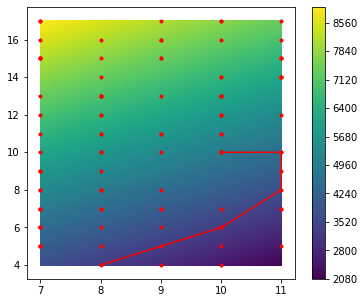

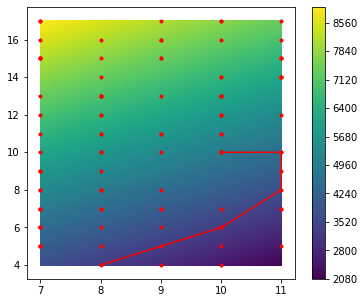

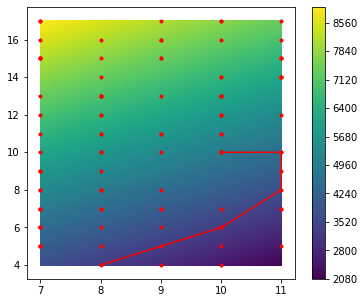

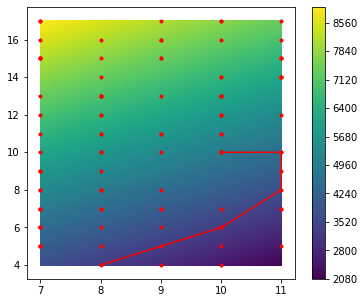

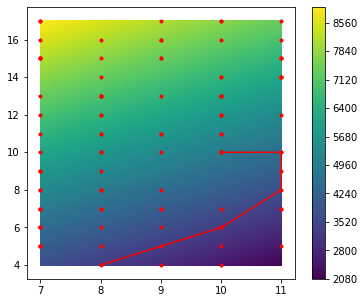

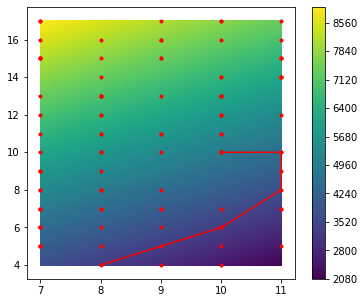

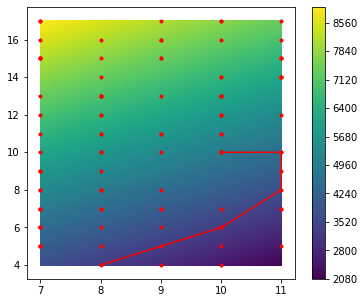

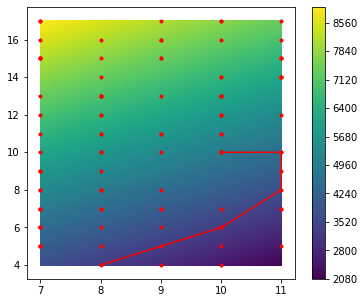

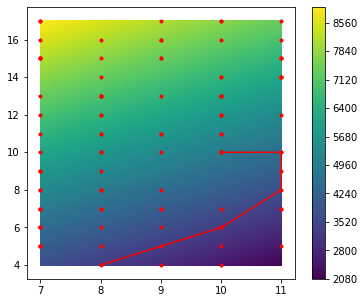

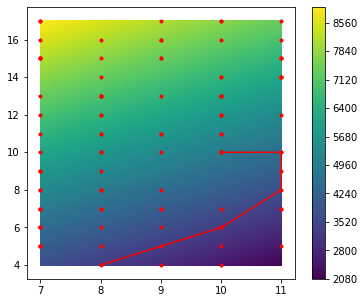

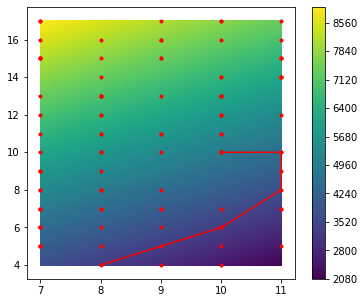

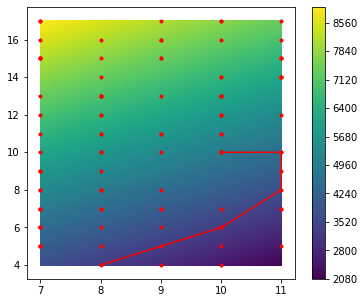

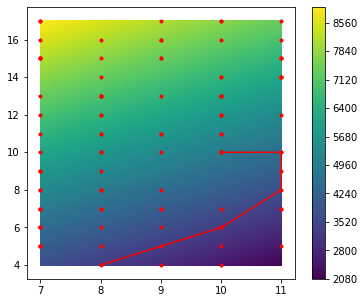

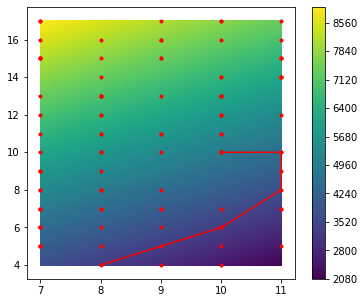

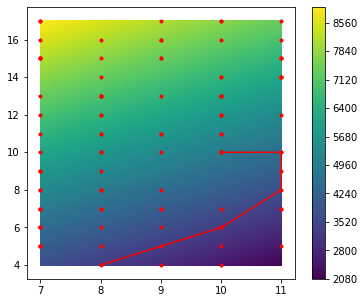

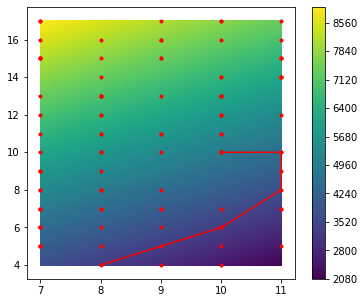

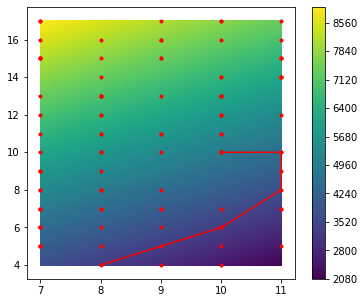

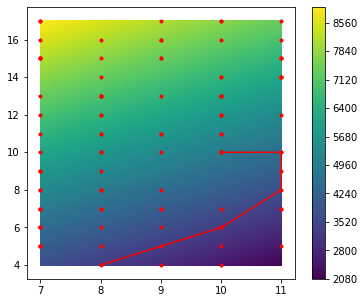

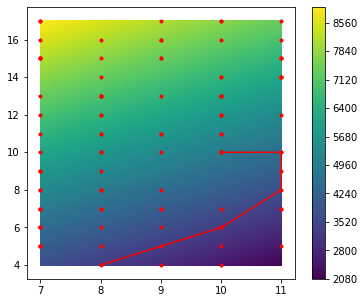

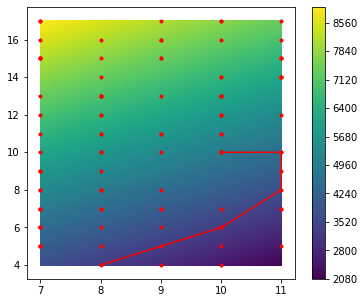

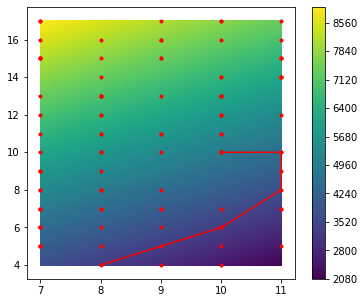

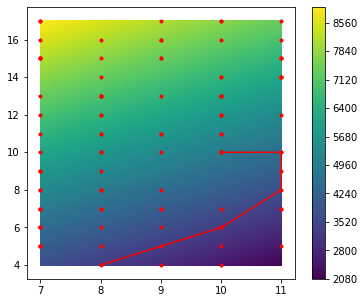

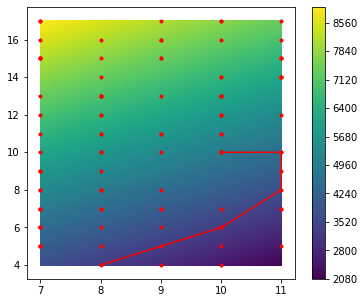

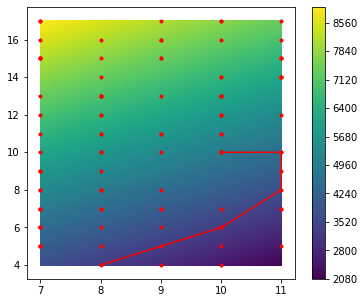

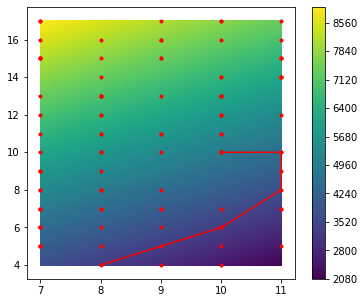

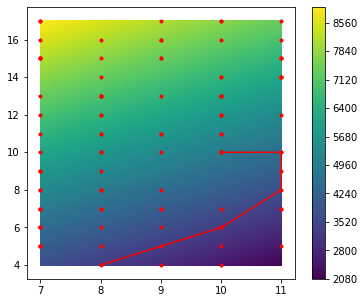

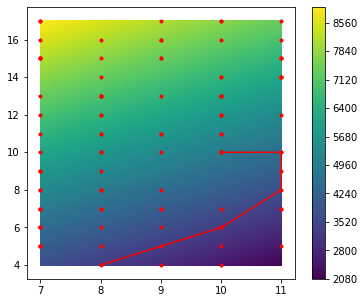

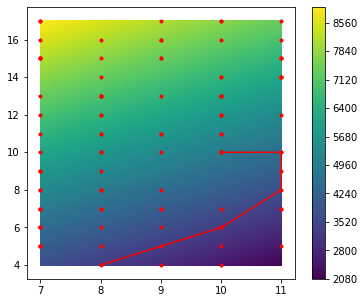

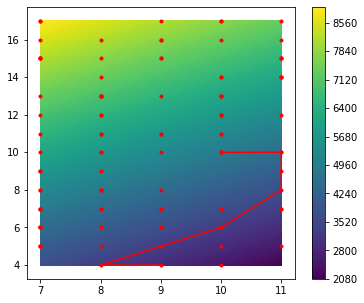

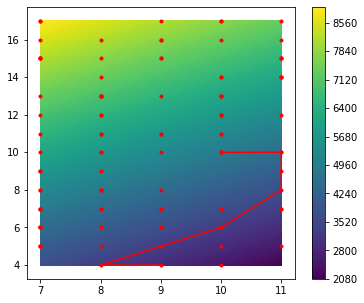

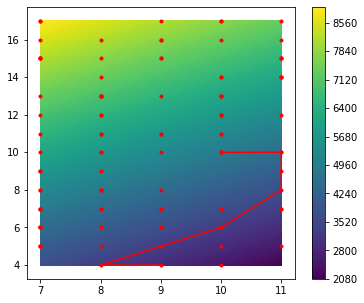

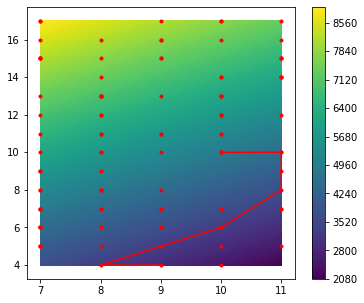

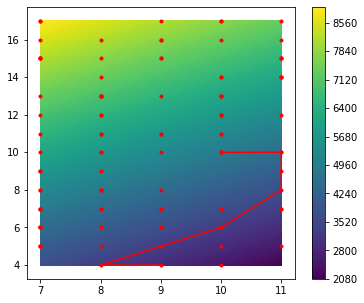

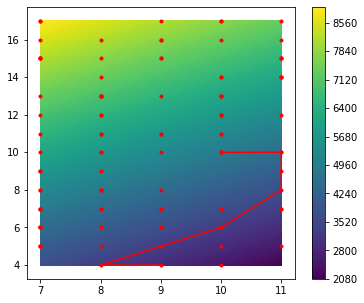

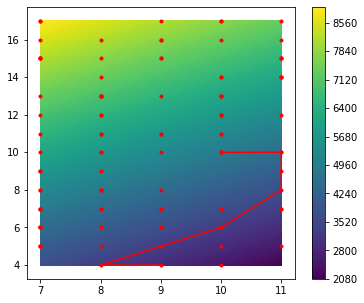

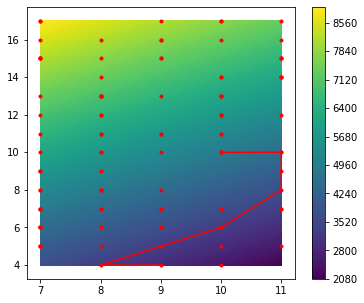

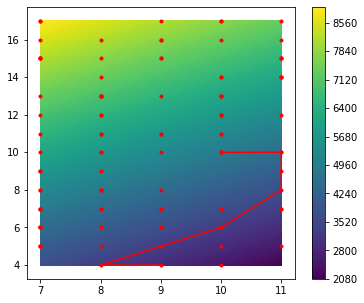

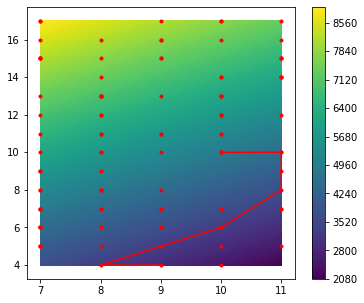

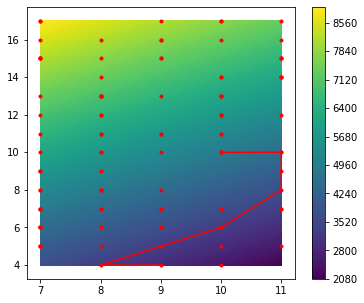

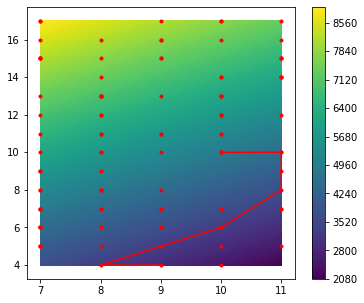

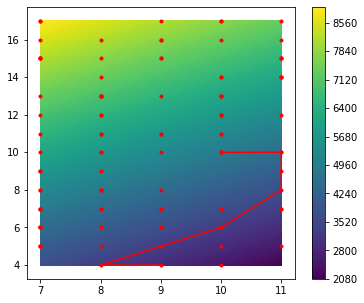

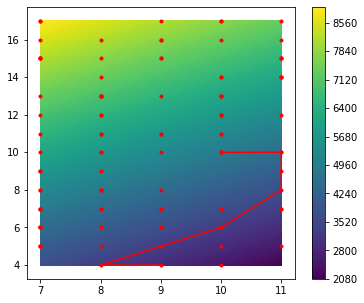

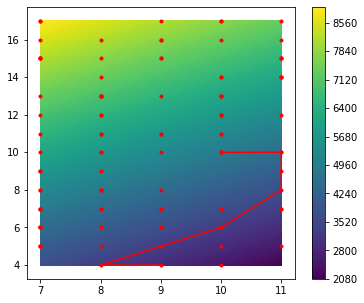

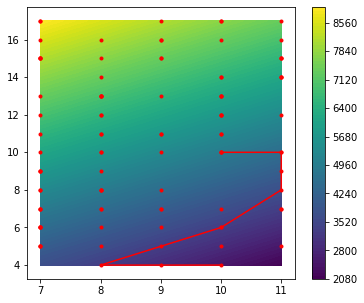

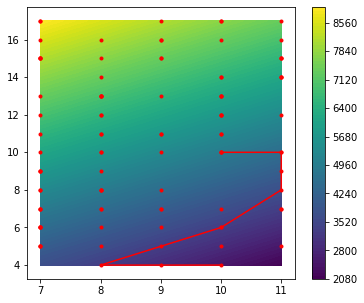

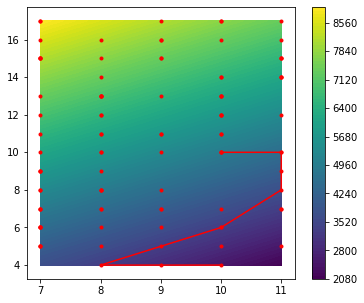

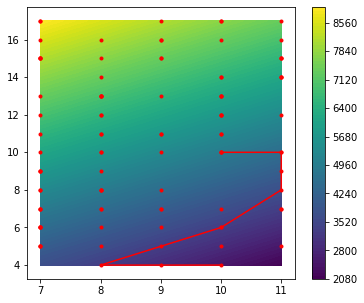

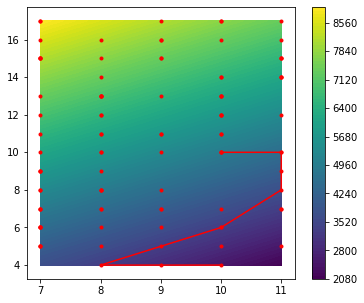

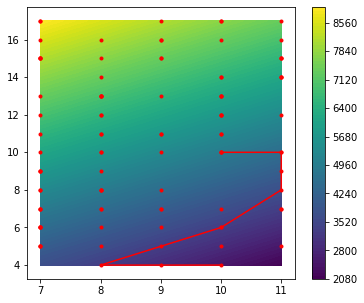

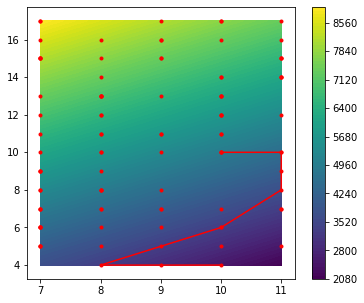

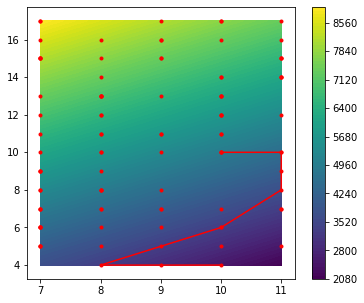

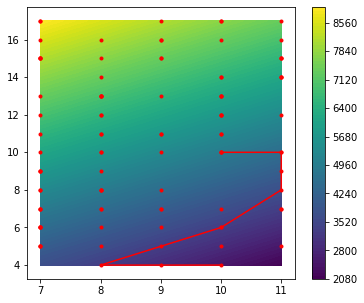

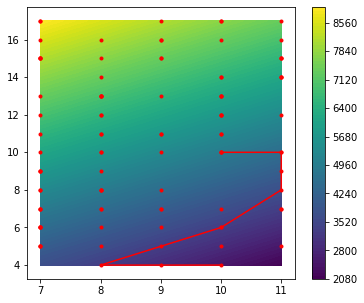

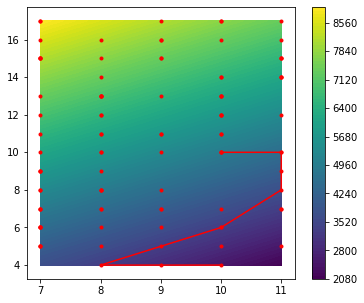

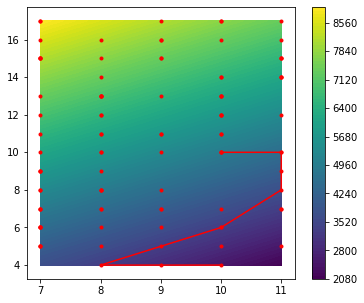

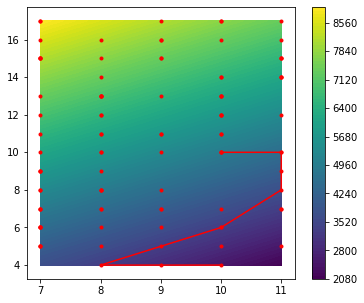

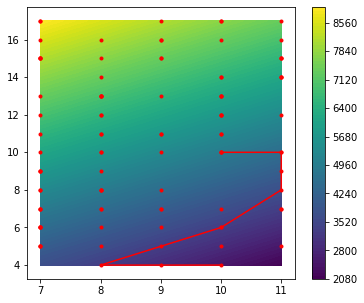

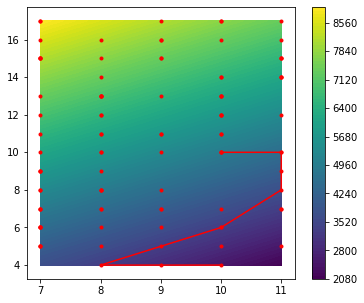

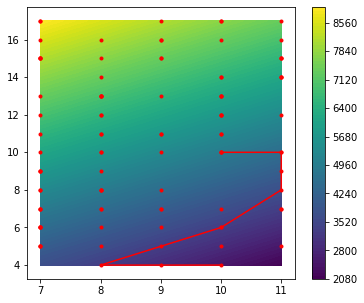

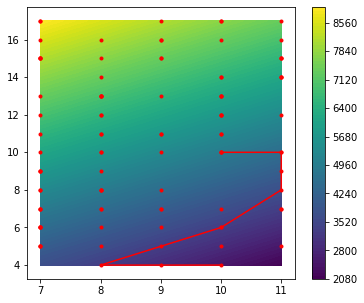

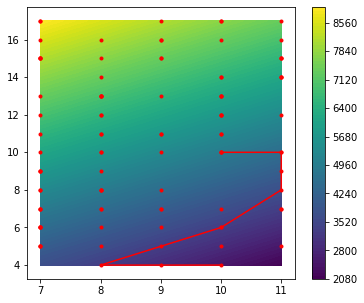

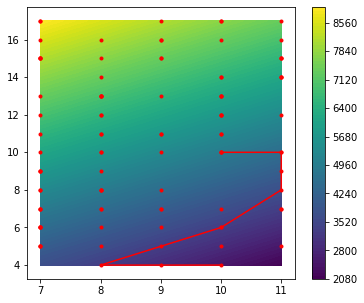

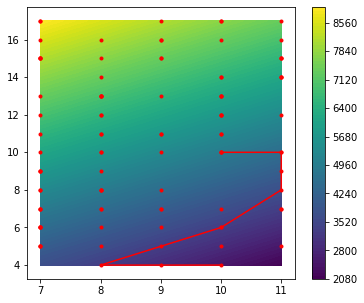

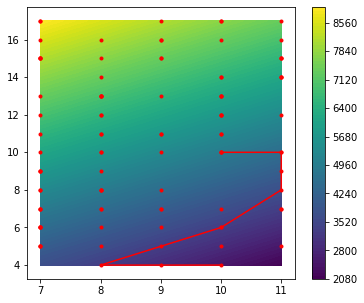

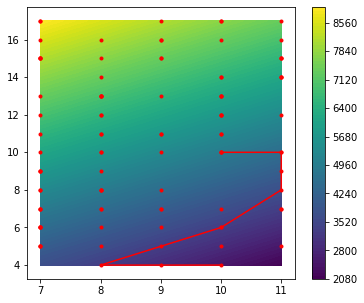

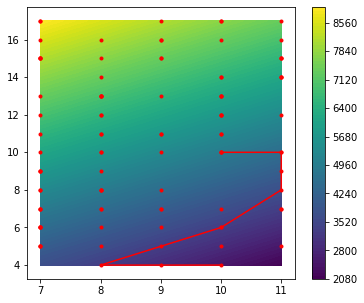

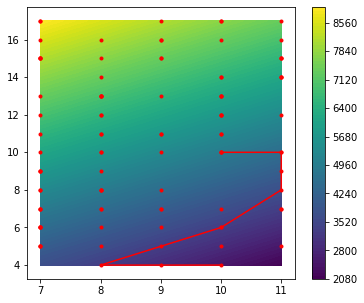

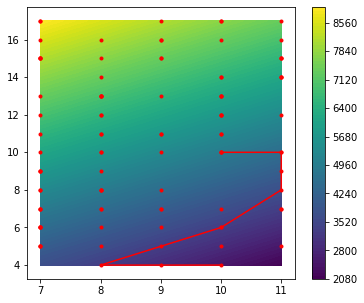

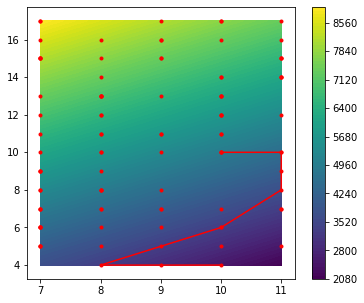

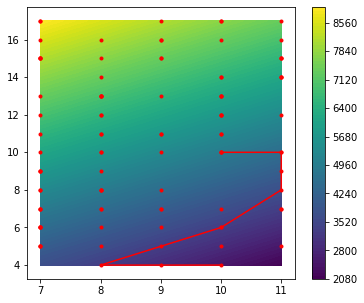

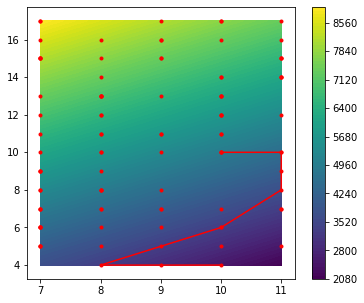

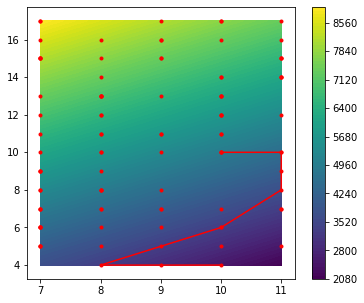

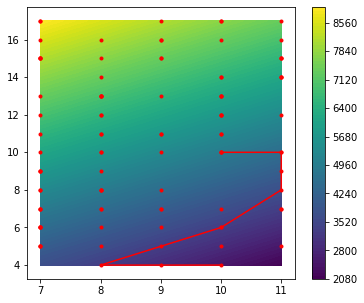

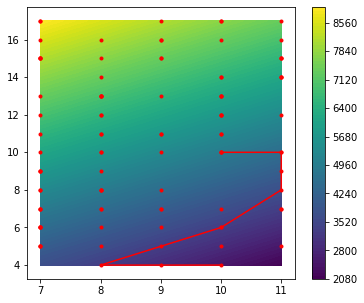

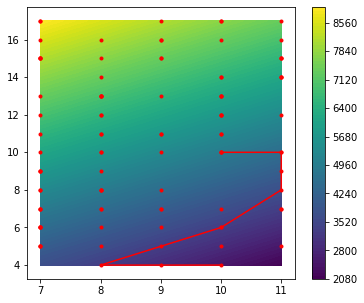

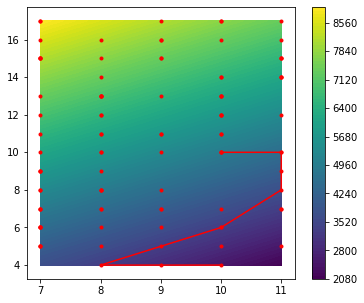

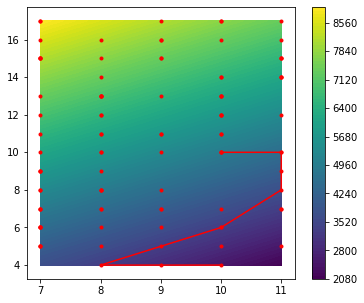

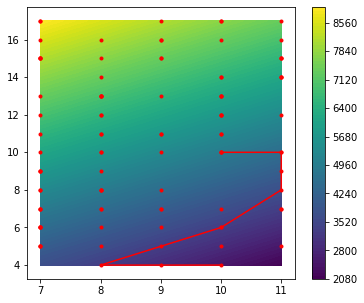

In [144]:
random.seed(41)
monte_carlo(100)

# References

[1] "What are the kinematic formulas? (article) | Khan Academy", Khan Academy, 2020. [Online]. Available: https://www.khanacademy.org/science/physics/one-dimensional-motion/kinematic-formulas/a/what-are-the-kinematic-formulas. [Accessed: 10- May- 2020].

[2] "scipy.stats.poisson — SciPy v1.4.1 Reference Guide", Docs.scipy.org, 2020. [Online]. Available: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html. [Accessed: 10- May- 2020].

[3] M. Farahmand et al., "Monte Carlo simulation of electron transport in the III-nitride wurtzite phase materials system: binaries and ternaries," in IEEE Transactions on Electron Devices, vol. 48, no. 3, pp. 535-542, March 2001, doi: 10.1109/16.906448.

[4] W. J. Thompson, "Poisson distributions," in Computing in Science & Engineering, vol. 3, no. 3, pp. 78-82, May-June 2001, doi: 10.1109/5992.919271.